<br>
<img align="center" width="400" src="oft.png">
<br>

# Algorithmic Trading

<img align="left" width="80" height="200" src="https://img.shields.io/badge/python-v3.6-blue.svg">
<br>

## Notebook by [Marco Tavora](https://marcotavora.me/)

### Table of contents

1. [Summary](#Summary)
1. [Definitions](#Definitions)
3. [Modules](#Modules)
4. [Time Series](#Time-Series)
5. [Strategy](#Strategy)
6. [Moving Windows](#Moving-Windows)

### Summary 
[[go back to the top]](#Table-of-contents)

I will briefly describe:
- How to build a [trend trading](https://en.wikipedia.org/wiki/Trend_following) strategy
- How to backtest it 
- How we can optimize it 

### Definitions 
[[go back to the top]](#Table-of-contents)


Trend trading can be [defined as](https://en.wikipedia.org/wiki/Trend_following):

> ... a trading strategy according to which one should buy an asset when its price trend goes up, and sell when its trend goes down, expecting price movements to continue.

Again borrowing from [Wikipedia](#https://en.wikipedia.org/wiki/Backtesting), backtesting:
> ... seeks to estimate the performance of a strategy or model if it had been employed during a past period. This requires simulating past conditions with sufficient detail, making one limitation of backtesting the need for detailed historical data. 

### Modules 
[[go back to the top]](#Table-of-contents)

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import quandl
import pandas_datareader as pdr
pd.core.common.is_list_like = pd.api.types.is_list_like
print(pdr.__version__)  # Make sure it is '0.4.1'.
from pandas_datareader import data as pdr
import fix_yahoo_finance

0.4.1


### Data from `yahoo` or `Quandl`
[[go back to the top]](#Table-of-contents)

In [40]:
start, end =datetime.datetime(2006, 10, 1), datetime.datetime(2012, 1, 1)
apple = pdr.get_data_yahoo('AAPL', start=start, end=end)
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,10.728572,10.838572,10.614285,10.694285,9.477872,178159800
2006-10-03,10.635715,10.707143,10.455714,10.582857,9.379119,197677200
2006-10-04,10.585714,10.780000,10.451428,10.768572,9.543709,207270700
2006-10-05,10.647142,10.880000,10.590000,10.690000,9.474073,170970800
2006-10-06,10.631429,10.720000,10.544286,10.602858,9.396842,116739700


In [41]:
start, end ="2006-10-01", "2012-01-01"
apple = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
apple.columns = [el.lower().replace('.', '').replace(' ', '_') for el in apple.columns]
apple.head()

,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
Date,,,,,,,,,,,,
2006-10-02,75.10,75.870,74.30,74.86,25451400.0,0.0,1.0,9.651397,9.750352,9.548586,9.620553,178159800.0
2006-10-03,74.45,74.950,73.19,74.07,28239600.0,0.0,1.0,9.567863,9.632120,9.405935,9.519027,197677200.0
2006-10-04,74.10,75.462,73.16,75.38,29610100.0,0.0,1.0,9.522883,9.697919,9.402080,9.687381,207270700.0
2006-10-05,74.53,76.160,74.13,74.83,24424400.0,0.0,1.0,9.578144,9.787621,9.526738,9.616698,170970800.0
2006-10-06,74.42,75.040,73.81,74.22,16677100.0,0.0,1.0,9.564007,9.643686,9.485614,9.538304,116739700.0


### New Column
[[go back to the top]](#Table-of-contents)

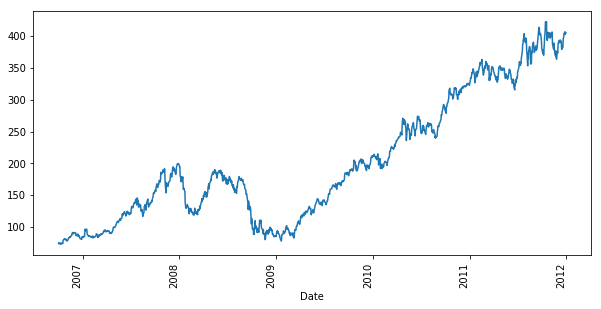

In [42]:
plt.rcParams['figure.figsize'] = 10, 5
apple['close'].plot(grid=False, rot=90);
plt.show();

### Strategy
[[go back to the top]](#Table-of-contents)

From [here](https://github.com/ranaroussi/fix-yahoo-finance) we get:

In [45]:
import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)

The strategy consists in:
- set the sizes of the short moving window `smw` and long moving window `lmw`
- Create an empty `DataFrame` for signals, called `signals`
- Fill the columns of `signals` with the short SMA and LMA
- Fill the `signal` column (starting from row `short_window`), inserting ones when the value of column `short_ma` is larger than `long_ma`
- Create a column of positions

In [87]:
smw, lmw = 40, 100
signals = pd.DataFrame(index=apple.index, columns = ['short_ma','long_ma' ])
signals['signal'], signals['short_ma'], signals['long_ma'] = 0.0, 0.0, 0.0

signals['short_ma'] = apple['close'].rolling(window=smw,
                                             min_periods=1, 
                                             center=False).mean()

signals['long_ma'] = apple['close'].rolling(window=lmw, 
                                            min_periods=1, 
                                            center=False).mean()
signals['signal'][smw:] = np.where(signals['short_ma'][smw:] 
                                            > signals['long_ma'][smw:], 1.0, 0.0)   


signals['positions'] = signals['signal'].diff()

signals.head()
signals.tail()

,short_ma,long_ma,signal,positions
Date,,,,
2006-10-02,74.860,74.860,0.0,NaN
2006-10-03,74.465,74.465,0.0,0.0
2006-10-04,74.770,74.770,0.0,0.0
2006-10-05,74.785,74.785,0.0,0.0
2006-10-06,74.672,74.672,0.0,0.0


,short_ma,long_ma,signal,positions
Date,,,,
2011-12-23,388.077375,387.84865,1.0,0.0
2011-12-27,388.116875,388.14025,0.0,-1.0
2011-12-28,388.063375,388.43045,0.0,0.0
2011-12-29,388.278625,388.94955,0.0,0.0
2011-12-30,388.468375,389.25945,0.0,0.0


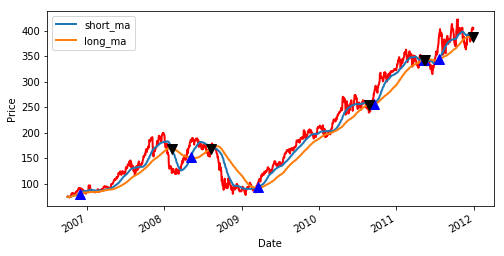

In [119]:
plt.rcParams['figure.figsize'] = 8, 4
fig = plt.figure();
ax1 = fig.add_subplot(111, ylabel='Price');
apple['close'].plot(ax=ax1, color='r', lw=2.);
signals[['short_ma', 'long_ma']].plot(ax=ax1, lw=2.);
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_ma[signals.positions == 1.0],
         '^', markersize=10, color='b');
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_ma[signals.positions == -1.0],
         'v', markersize=10, color='black');
plt.show();

### Backtesting
[[go back to the top]](#Table-of-contents)

Steps:
- Set the initial capital
- Create a DataFrame `positions`
- Buy a 100 shares
- Initialize the portfolio with value owned   
- Store the difference in shares owned 
- Add `holdings` to portfolio
- Add `cash` to portfolio
- Add `total` to portfolio
- Add `returns` to portfolio
- Plot the equity curve in dollars
- Plot the "buy" trades against the equity curve
- Plot the "sell" trades against the equity curve

In [123]:
initial_capital = 2000000.0
positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions['AAPL'] = 100*signals['signal']   
portfolio = positions.multiply(apple['adj_close'], axis=0)
pos_diff = positions.diff()
portfolio['holdings'] = (positions.multiply(apple['adj_close'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(apple['adj_close'], axis=0)).sum(axis=1).cumsum()   
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()

portfolio.head()

,AAPL,holdings,cash,total,returns
Date,,,,,
2006-10-02,0.0,0.0,2000000.0,2000000.0,NaN
2006-10-03,0.0,0.0,2000000.0,2000000.0,0.0
2006-10-04,0.0,0.0,2000000.0,2000000.0,0.0
2006-10-05,0.0,0.0,2000000.0,2000000.0,0.0
2006-10-06,0.0,0.0,2000000.0,2000000.0,0.0


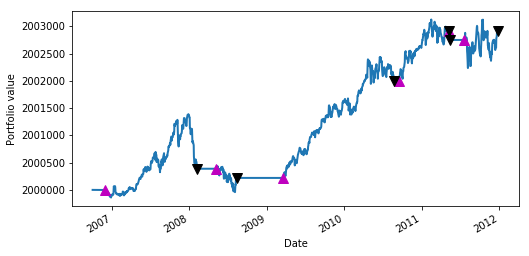

In [124]:
plt.rcParams['figure.figsize'] = 8, 4
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Portfolio value')
portfolio['total'].plot(ax=ax1, lw=2.)
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')
plt.show();

### Sharpe Ratio, Maximum Drawdown and CAGR
[[go back to the top]](#Table-of-contents)

sharpe_ratio is: 0.72


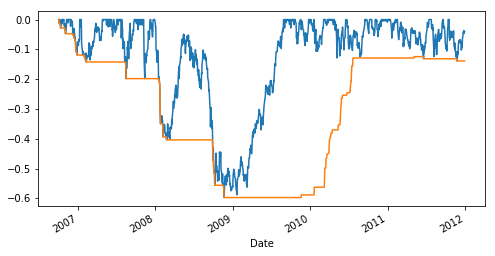

In [125]:
returns = portfolio['returns']
sharpe_ratio = np.sqrt(252)*(returns.mean() / returns.std())
print('sharpe_ratio is:',round(sharpe_ratio, 3))

window = 252
rolling_max = apple['adj_close'].rolling(window, min_periods=1).max()
daily_drawdown = apple['adj_close']/rolling_max - 1.0
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.show();

In [126]:
days = (apple.index[-1] - apple.index[0]).days
cagr = ((((apple['adj_close'][-1]) / apple['adj_close'][1])) ** (365.0/days)) - 1
print('cagr is:', round(cagr, 2))

cagr is: 0.38
